In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [2]:
train = pd.read_csv("./data.csv")

In [3]:
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,509,147,621,254
1,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,444,146,514,258
2,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,345,219,457,328
3,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,287,340,407,445
4,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,1,154,86,245


In [4]:
train['xmin'],train['xmax'] = train['xmin'] / 640,train['xmax'] / 640
train['ymin'],train['ymax'] = train['ymin'] / 480,train['ymax'] / 480

In [5]:
train.head(2)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,0.795312,0.306250,0.970313,0.529167
1,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,0.693750,0.304167,0.803125,0.537500


In [6]:
data = []
grouped = train.groupby(by='filename')

for i in train.filename.unique():
    boxes = list(grouped.get_group(i)[['class','xmin','ymin','xmax','ymax']].T.to_dict().values())
    data.append({
        'filename':i,
        'boxes':boxes
    })

In [7]:
data[0]

{'filename': './JPEGImages/BloodImage_00266.jpg',
 'boxes': [{'class': 'RBC',
   'xmin': 0.7953125,
   'ymin': 0.30625,
   'xmax': 0.9703125,
   'ymax': 0.5291666666666667},
  {'class': 'RBC',
   'xmin': 0.69375,
   'ymin': 0.30416666666666664,
   'xmax': 0.803125,
   'ymax': 0.5375},
  {'class': 'RBC',
   'xmin': 0.5390625,
   'ymin': 0.45625,
   'xmax': 0.7140625,
   'ymax': 0.6833333333333333},
  {'class': 'RBC',
   'xmin': 0.4484375,
   'ymin': 0.7083333333333334,
   'xmax': 0.6359375,
   'ymax': 0.9270833333333334},
  {'class': 'RBC',
   'xmin': 0.0015625,
   'ymin': 0.32083333333333336,
   'xmax': 0.134375,
   'ymax': 0.5104166666666666},
  {'class': 'RBC',
   'xmin': 0.4734375,
   'ymin': 0.18125,
   'xmax': 0.6078125,
   'ymax': 0.37083333333333335},
  {'class': 'RBC',
   'xmin': 0.59375,
   'ymin': 0.025,
   'xmax': 0.728125,
   'ymax': 0.21458333333333332},
  {'class': 'RBC',
   'xmin': 0.8796875,
   'ymin': 0.5229166666666667,
   'xmax': 0.9984375,
   'ymax': 0.7291666666666

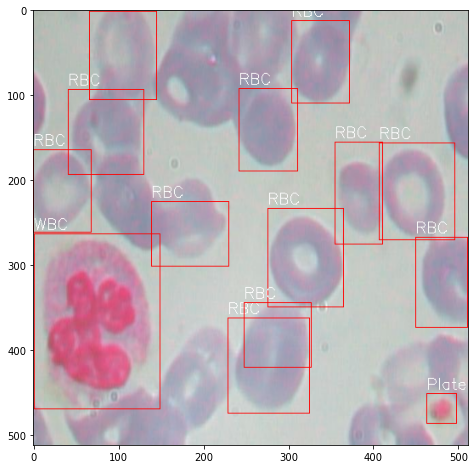

In [8]:
image = data[0]

img = cv2.imread(image['filename'])
img = cv2.resize(img,(512,512))

for box in image['boxes']:
    img = cv2.putText(img,box['class'],(int(box['xmin']*512),int(box['ymin']*512)-5),cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,255,255))
    img = cv2.rectangle(
            img,
            (int(box['xmin']*512),int(box['ymin']*512)),
            (int(box['xmax']*512),int(box['ymax']*512)),
            (255,0,0),
            1
        )

plt.figure(figsize=(12,8))
plt.imshow(img)

In [9]:
images = np.array([cv2.imread(i['filename']) for i in data])

In [10]:
ratios = np.array([
        [12,12],
        [16,8],
        [8,16],
        [24,24],
        [32,16],
        [16,32],
        [48,48],
        [64,32],
        [32,64]
    ])

sizes = ratios * 2

def get_anchors(input_shape = (512,512),grid_size= 16,n_classes=3):
    """
    generates anchor boxes, dummy scores and grid
    returns boxes,scores,grid
    
    input_shape : tuple, input image shape (height,width)
    grid_size   : int, size of grid
    """
    x = np.arange(0,input_shape[0],input_shape[0]//grid_size)
    y = np.arange(0,input_shape[1],input_shape[1]//grid_size)
    xx,yy =np.meshgrid(x,y)
    xx = xx.reshape(-1,grid_size,1)
    yy = yy.reshape(-1,grid_size,1)
    grid = np.concatenate((xx,yy),axis=2)
    boxes = []
    for r in ratios:
        mn = grid - r
        mx = grid + r
        box = np.concatenate((mn,mx),axis=2)
        box[box > 512] = 512
        box[box < 0] = 0
        boxes.append(box)
        
    scores = np.zeros((9,grid_size,grid_size,n_classes+1),dtype=np.float32)
    scores[:,:,:,0] = 1.0
    return np.array(boxes),scores,grid

In [11]:
boxes,scores_,grid = get_anchors()

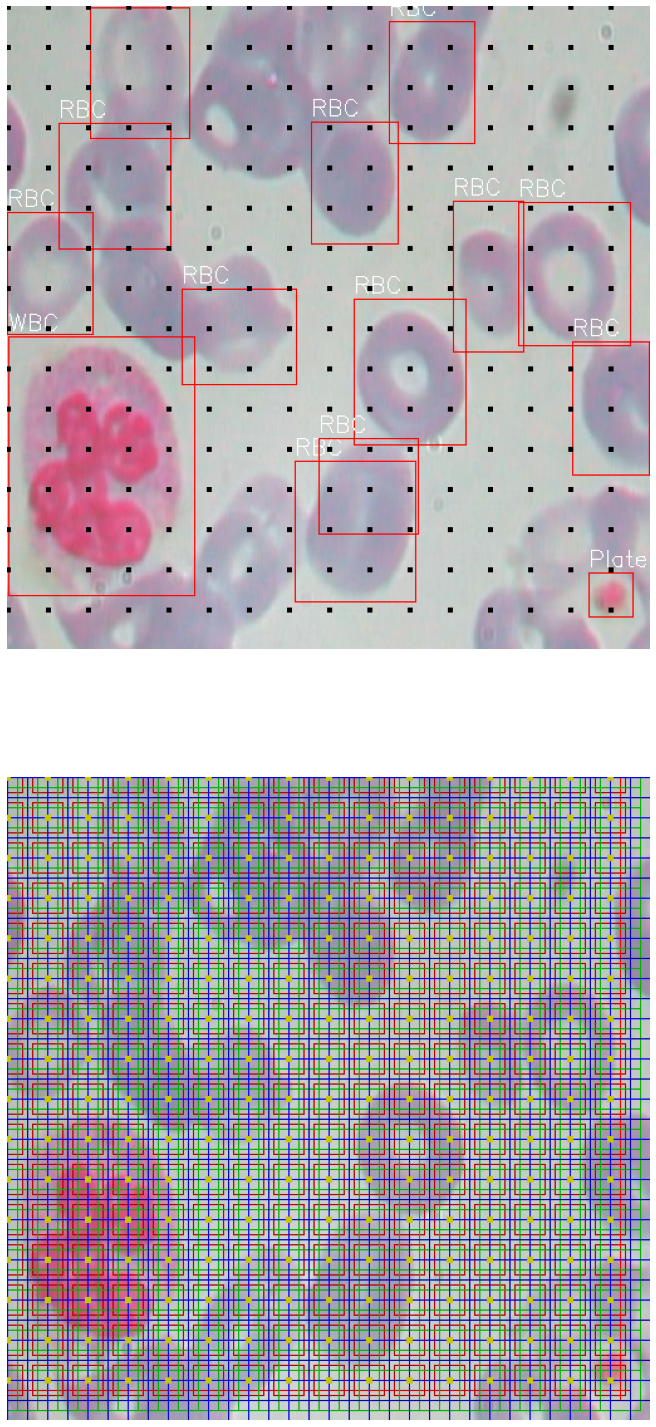

In [12]:
image = data[0]
img = cv2.imread(image['filename'])

img = cv2.resize(img,(512,512))

grid_img = img.copy()
box_img = img.copy()

box_colors = [
    (180,0,0),
    (220,0,0),
    (255,0,0),
    (0,180,0),
    (0,220,0),
    (0,255,0),
    (0,0,180),
    (0,0,220),
    (0,0,255),
]

boxes,scores,grid = get_anchors()

for box in image['boxes']:
    grid_img = cv2.putText(grid_img,box['class'],(int(512*box['xmin']),int(512*box['ymin'])-5),cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,255,255))
    grid_img = cv2.rectangle(
                    grid_img,
                    (int(512*box['xmin']),int(512*box['ymin'])),
                    (int(512*box['xmax']),int(512*box['ymax'])),
                    (255,0,0),
                    1
            )

for x,y in grid.reshape(-1,2):
    grid_img = cv2.rectangle(grid_img,(x-1,y-1),(x+2,y+2),(0,0,0),-1)
    

for i,b in enumerate(boxes):
    for xmin,ymin,xmax,ymax in b.reshape(-1,4).astype(np.uint64):#[136:137]:
        box_img = cv2.rectangle(box_img,(xmin,ymin),(xmax,ymax),box_colors[i],1)

for x,y in grid.reshape(-1,2):#[136:137]:
    box_img = cv2.rectangle(box_img,(x-2,y-2),(x+2,y+2),(200,200,0),-1)
        

fig,axes = plt.subplots(2,1,figsize=(13,26))
axes[0].axis("off"),axes[1].axis("off")

axes[0].imshow(grid_img)
axes[1].imshow(box_img)

In [13]:

def get_closest(x,y,w,h,grid_size=32):
    """
    finds closest grid points for the given point on image
    returns : grid
    
    x : int, x 
    y : int, y
    w : int, height of the box
    h : int, width of the box
    grid_size : strides 
    """
    dx,dy = x//grid_size,y//grid_size
    xx = []
    yy = []
    distX = np.square((dx*grid_size)-x)
    distY = np.square((dy*grid_size)-y)
    
    if distX > 256:
        dx += 1
    if distY > 256:
        dy += 1
    
    if w > 144:
        xx = [(dx)*grid_size,(dx+1)*grid_size,(dx-1)*grid_size]
    elif w > 96:
        xx = [(dx)*grid_size,(dx+1)*grid_size if ((dx*grid_size)-x) <=0 else (dx-1)*grid_size]
    else:
        xx = [(dx)*grid_size]
    
    if h > 144:
        yy = [(dy)*grid_size,(dy+1)*grid_size,(dy-1)*grid_size]
    elif h > 96:
        yy = [(dy)*grid_size,(dy+1)*grid_size if ((dy*grid_size)-y) <=0 else (dy-1)*grid_size]
    else:
        yy = [(dy)*grid_size]
    
    xx,yy =np.meshgrid(xx,yy)
    xx = xx.reshape(-1,len(xx),1)
    yy = yy.reshape(-1,len(yy),1)
    grid = np.concatenate((xx,yy),axis=2).reshape(-1,2)    
    grid[grid > 480] = 480
    return grid


In [14]:
sizes = ratios.copy() * 2

In [15]:
sizes = ratios.copy() * 2

size_map={
    [16,16].__str__():[[24,24],[16,32],[32,16]],
    [16,24].__str__():[[24,24],[16,32]],
    [16,32].__str__():[[16,32]],
    [16,48].__str__():[[32,32],[16,32],[32,16]],
    [16,64].__str__():[[32,64]],
    [16,96].__str__():[[48,48]],
    [16,128].__str__():[[64,128],[16,32]],
    
    [24,16].__str__():[[24,24],[32,16]],
    [24,24].__str__():[[24,24]],
    [24,32].__str__():[[32,16],[24,24],[16,32]],
    [24,48].__str__():[[48,48],[24,24]],
    [24,64].__str__():[[32,64],[24,24]],
    [24,96].__str__():[[24,24],[32,64],[64,32]],
    [24,128].__str__():[[64,128],[24,24]],
    
    [32,16].__str__():[[32,16]],
    [32,24].__str__():[[32,16],[24,24],[16,32]],
    [32,32].__str__():[[32,64],[64,32],[48,48]],
    [32,48].__str__():[[32,64],[48,48]],
    [32,64].__str__():[[32,64]],
    [32,96].__str__():[[32,64],[96,96]],
    [32,128].__str__():[[64,128]],
    
    [48,16].__str__():[[32,32],[16,32],[32,16]],
    [48,24].__str__():[[48,48],[24,24]],
    [48,32].__str__():[[64,32],[48,48]],
    [48,48].__str__():[[48,48]],
    [48,64].__str__():[[32,64],[48,48]],
    [48,96].__str__():[[96,96]],
    [48,128].__str__():[[64,128],[48,48]],
    
    [64,16].__str__():[[64,32]],
    [64,24].__str__():[[64,24],[24,24]],
    [64,32].__str__():[[64,32]],
    [64,48].__str__():[[64,32],[48,48]],
    [64,64].__str__():[[32,64],[64,32],[48,48]],
    [64,96].__str__():[[96,96],[64,32],[32,64]],
    [64,128].__str__():[[64,128]],
    
    [96,16].__str__():[[48,48],[96,96]],
    [96,24].__str__():[[24,24],[32,64],[64,32]],
    [96,32].__str__():[[64,32],[96,96]],
    [96,48].__str__():[[96,96]],
    [96,64].__str__():[[96,96],[64,32],[32,64]],
    [96,96].__str__():[[96,96]],
    [96,128].__str__():[[96,96],[64,128]],
    
    [128,16].__str__():[[128,64],[32,16]],    
    [128,24].__str__():[[128,64],[24,24]],
    [128,32].__str__():[[128,32]],
    [128,48].__str__():[[128,64],[48,48]],
    [128,64].__str__():[[128,64]],
    [128,96].__str__():[[64,128],[128,64],[96,96]],
    [128,128].__str__():[[64,128],[128,64],[96,96]],
}


def get_sized_boxes(w,h):
    """
    finds the closest widths and heights for the boundig box
    returns : sized_boxes 
    
    w : int, width of the bounding box
    h : int, height of the bounding box
    """
    
    mw = min((sizes[:,0][sizes[:,0] >= w].tolist() or [128]))
    mh = min((sizes[:,1][sizes[:,1] >= h].tolist() or [128]))
    return size_map[[mw,mh].__str__()]

class_map = {
    "RBC":1,
    "WBC":2,
    "Platelets":3
}

def get_labeled_boxes(classes,boxes):
    """
    labels every box individually 
    returns : labeled boxes
    
    classes : arr, (n,1) classes
    boxes   : arr, (n,4) corresponding boxes
    """
    labeled_boxes = []    
    for cls,(xmin,ymin,xmax,ymax) in zip(classes,boxes):
        w = (xmax-xmin)
        h = (ymax-ymin)
        x,y = xmin + w//2 , ymin + h//2
        closest = get_closest(x,y,w,h)
        sized_boxes = get_sized_boxes(w,h)
        c_index = [sizes.tolist().index(i) for i in sized_boxes]
        true_boxes = closest//32
        labeled_boxes.append({
            "closest":closest,
            "c_index":c_index,
            "true_boxes":true_boxes,
            "sized_boxes":sized_boxes,
            "class":class_map[cls]
        })
    
    return labeled_boxes

In [16]:
def label_image(image,n_classes=3):
    """
    generates anchors and scores for the image provided
    returns : image,boxes,scores,grid,labeled_boxes
    
    image : dict 
    """
    boxes_ = np.array([[int(i['xmin']*512),int(i['ymin']*512),int(i['xmax']*512),int(i['ymax']*512)] for i in image['boxes']])
    classes_ = [i['class'] for i in image['boxes']]
    
    boxes,scores,grid = get_anchors()
    labeled_boxes = get_labeled_boxes(classes_,boxes_)

    for label in labeled_boxes:
        for c in label['c_index']:
            for x,y in label['true_boxes']:
                score = np.zeros(n_classes+1,dtype=np.float32)
                score[label['class']] = 1.0
                scores[c][[y],[x]] = score
    
    return cv2.imread(image['filename']),boxes,scores,grid,labeled_boxes
    

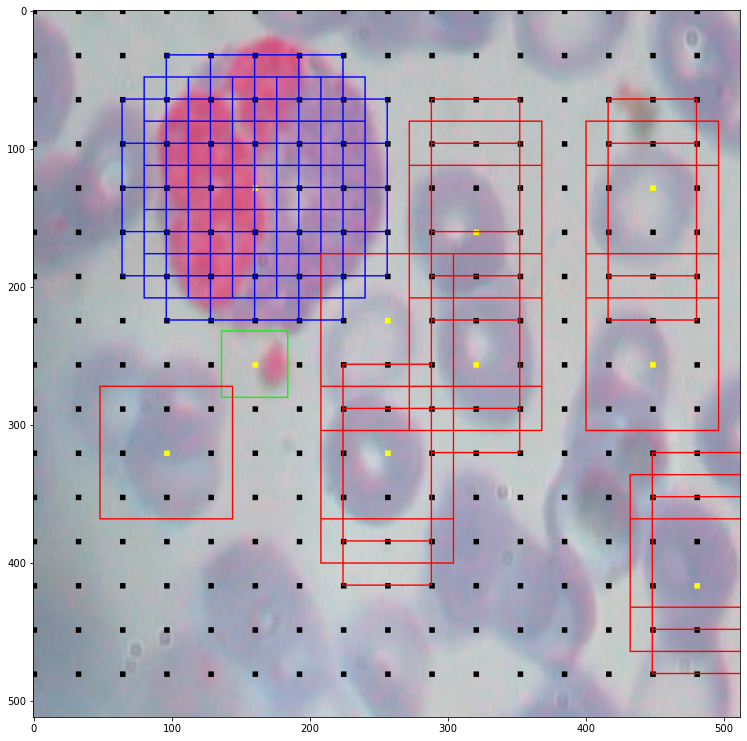

In [17]:
img = data[6].copy()

img,boxes,scores,grid,labeled_boxes = label_image(img)

img = cv2.resize(img,(512,512))

for x,y in grid.reshape(-1,2):
    img = cv2.rectangle(img,(x-1,y-1),(x+2,y+2),(0,0,0),-1)

for l in labeled_boxes:
    x,y = l['closest'][0]
    img = cv2.rectangle(img,(x-1,y-1),(x+2,y+2),(255,255,0),-1)

c = [
    (255,255,255),
    (255,0,0),
    (0,0,255),
    (0,255,0)
]

for score,(xmin,ymin,xmax,ymax) in zip(scores.reshape(-1,4),boxes.reshape(-1,4)):
    score = score.argmax()
    if score:
        img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax),c[int(score)],1)
    
plt.figure(figsize=(13,13))
plt.imshow(img)

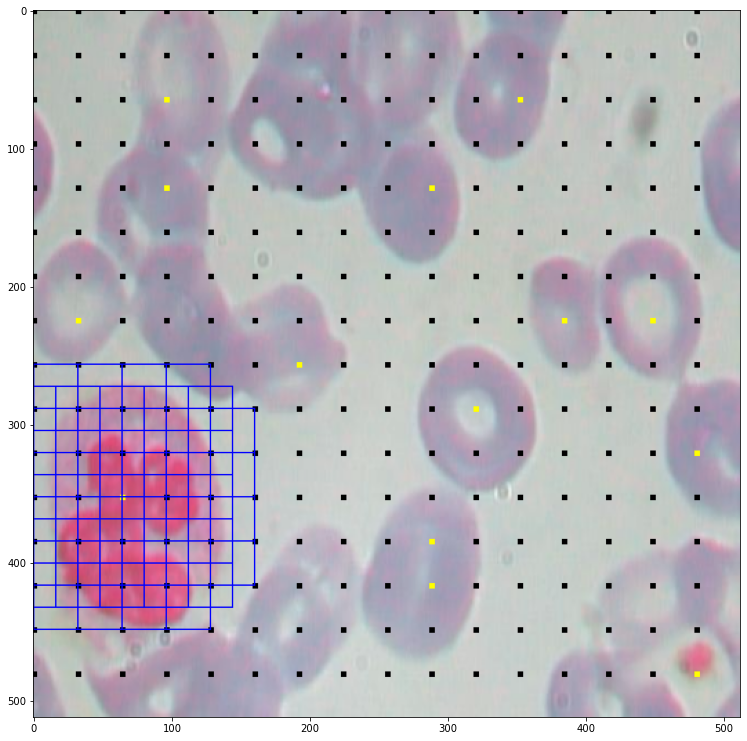

In [22]:
i = 0

img = data[i].copy()
img,boxes,scores,grid,labeled_boxes = label_image(img)
img = cv2.resize(img,(512,512))
for x,y in grid.reshape(-1,2):
    img = cv2.rectangle(img,(x-1,y-1),(x+2,y+2),(0,0,0),-1)

for l in labeled_boxes:
    x,y = l['closest'][0]
    img = cv2.rectangle(img,(x-1,y-1),(x+2,y+2),(255,255,0),-1)

c = [
    (255,255,255),
    (255,0,0),
    (0,0,255),
    (0,255,0)
]

b_ = []

for score,(xmin,ymin,xmax,ymax) in zip(scores.reshape(-1,4),boxes.reshape(-1,4)):
    score = score.argmax()
    if score == 2:
        b_.append([xmin,ymin,xmax,ymax])
        img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax),c[int(score)],1)
    
plt.figure(figsize=(13,13))
plt.imshow(img)

In [28]:
[[ymax-ymin,xmax-xmin] for xmin,ymin,xmax,ymax in b_]

[[96, 80],
 [96, 96],
 [96, 96],
 [96, 80],
 [96, 96],
 [96, 96],
 [96, 80],
 [96, 96],
 [96, 96],
 [64, 96],
 [64, 128],
 [64, 128],
 [64, 96],
 [64, 128],
 [64, 128],
 [64, 96],
 [64, 128],
 [64, 128],
 [128, 64],
 [128, 64],
 [128, 64],
 [128, 64],
 [128, 64],
 [128, 64],
 [128, 64],
 [128, 64],
 [128, 64]]

In [19]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K

In [ ]:
class FeatureExtractor(keras.Model):
    """
    Generates A 256 x 256 x 6 Feature Map For Classifier
    """
    def __init__(self):
        super(FeatureExtractor,self).__init__()
        n = 'a'
        self.block_a_conv1 = layers.Conv2D(128,2,padding="same",activation="relu",name=f"block_{n}_conv_1")
        self.block_a_conv2 = layers.Conv2D(128,3,padding="same",activation="relu",name=f"block_{n}_conv_2")
        self.block_a_norm = layers.BatchNormalization(name=f"block_{n}_norm")
        self.block_a_conv3 = layers.Conv2D(128,3,padding="same",activation="relu",name=f"block_{n}_conv_3")
        self.block_a_pool = layers.MaxPool2D(name=f"block_{n}_pool")

        n = 'b'
        self.block_b_conv1 = layers.Conv2D(128,2,padding="same",activation="relu",name=f"block_{n}_conv_1")
        self.block_b_conv2 = layers.Conv2D(128,3,padding="same",activation="relu",name=f"block_{n}_conv_2")
        self.block_b_norm = layers.BatchNormalization(name=f"block_{n}_norm")
        self.block_b_conv3 = layers.Conv2D(128,3,padding="same",activation="relu",name=f"block_{n}_conv_3")
        self.block_b_upscale = layers.UpSampling2D()
        
        n = 'c'
        self.block_c_conv1 = layers.Conv2D(128,2,padding="same",activation="relu",name=f"block_{n}_conv_1")
        self.block_c_conv2 = layers.Conv2D(128,3,padding="same",activation="relu",name=f"block_{n}_conv_2")
        self.block_c_norm = layers.BatchNormalization(name=f"block_{n}_norm")
        self.block_c_conv3 = layers.Conv2D(128,3,padding="same",activation="relu",name=f"block_{n}_conv_3")
        self.block_c_pool = layers.MaxPool2D(name=f"block_{n}_pool")
    
        self.feat_map = layers.Conv2D(6,1,activation="relu",name="features")
        
    def __call__(self, x):
        x = tf.cast(x,tf.float32)
        x = tf.image.resize(x,(512,512),tf.image.ResizeMethod.BICUBIC)
        
        x = self.block_a_conv1(x)
        x = self.block_a_conv2(x)
        x = self.block_a_norm(x)
        x = self.block_a_conv3(x)
        x = self.block_a_pool(x)
        
        x = self.block_b_conv1(x)
        x = self.block_b_conv2(x)
        x = self.block_b_norm(x)
        x = self.block_b_conv3(x)
        x = self.block_b_upscale(x)
        
        x = self.block_c_conv1(x)
        x = self.block_c_conv2(x)
        x = self.block_c_norm(x)
        x = self.block_c_conv3(x)
        x = self.block_c_pool(x)
        
        x = self.feat_map(x)
        
        return x



In [138]:
class Classifier(keras.models.Model):
    """
    Generates 2304 Anchors With Confidence Score, in following box sizes. 
    
    12 x 12
    16 x 8
    8  x 16
    
    24 x 24
    32 x 16
    16 x 32
    
    48 x 48
    64 x 32
    32 x 64
    
    """
        
    def __init__(self,n_classes=3):
        super(Classifier,self).__init__()
        self.n_classes = n_classes + 1
        
        self.box_24_24 = layers.Conv2D(self.n_classes,(12,12),strides=16,activation="softmax",padding="same")
        self.box_32_16 = layers.Conv2D(self.n_classes,(16,8),strides=16,activation="softmax",padding="same")
        self.box_16_32 = layers.Conv2D(self.n_classes,(8,16),strides=16,activation="softmax",padding="same")
        
        self.box_48_48 = layers.Conv2D(self.n_classes,(24,24),strides=16,activation="softmax",padding="same")
        self.box_64_32 = layers.Conv2D(self.n_classes,(32,16),strides=16,activation="softmax",padding="same")
        self.box_32_64 = layers.Conv2D(self.n_classes,(16,32),strides=16,activation="softmax",padding="same")

        self.box_96_96 = layers.Conv2D(self.n_classes,(48,48),strides=16,activation="softmax",padding="same")
        self.box_128_64 = layers.Conv2D(self.n_classes,(64,32),strides=16,activation="softmax",padding="same")
        self.box_64_128 = layers.Conv2D(self.n_classes,(32,64),strides=16,activation="softmax",padding="same")
        
    def __call__(self,x):
        x0 = tf.reshape(self.box_24_24(x),(-1,1,16,16,self.n_classes))
        x1 = tf.reshape(self.box_32_16(x),(-1,1,16,16,self.n_classes))
        x2 = tf.reshape(self.box_16_32(x),(-1,1,16,16,self.n_classes))
        
        x3 = tf.reshape(self.box_48_48(x),(-1,1,16,16,self.n_classes))
        x4 = tf.reshape(self.box_64_32(x),(-1,1,16,16,self.n_classes))
        x5 = tf.reshape(self.box_32_64(x),(-1,1,16,16,self.n_classes))
        
        x6 = tf.reshape(self.box_96_96(x),(-1,1,16,16,self.n_classes))
        x7 = tf.reshape(self.box_128_64(x),(-1,1,16,16,self.n_classes))
        x8 = tf.reshape(self.box_64_128(x),(-1,1,16,16,self.n_classes))

        x = tf.concat([x0,x1,x2,x3,x4,x5,x6,x7,x8],axis=1)
        x = tf.reshape(x,(len(x),-1,4))
        
        return x